In [ ]:
!unzip BCCD.v4-416x416_aug.coco.zip -d data/

Archive:  BCCD.v4-416x416_aug.coco.zip
 extracting: data/README.dataset.txt  
 extracting: data/README.roboflow.txt  
   creating: data/test/
 extracting: data/test/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg  
 extracting: data/test/BloodImage_00044_jpg.rf.e7760375eba4bc20c5746367e2311e18.jpg  
 extracting: data/test/BloodImage_00062_jpg.rf.1be1ca0ecdf783798fc10346baaa203e.jpg  
 extracting: data/test/BloodImage_00090_jpg.rf.cdbf8f6ed3b93fa902a0bc991132cb40.jpg  
 extracting: data/test/BloodImage_00099_jpg.rf.e3c42cd68359527494a53843479dff5c.jpg  
 extracting: data/test/BloodImage_00112_jpg.rf.978cec39235980055c2ad7ff8b6f1912.jpg  
 extracting: data/test/BloodImage_00113_jpg.rf.a17463f1ddc2e7729f935f8a74bc86a4.jpg  
 extracting: data/test/BloodImage_00120_jpg.rf.6725d54bf5615683448eb1de4c7577ee.jpg  
 extracting: data/test/BloodImage_00133_jpg.rf.39ee4e4a097a7b40defa56aea6533caf.jpg  
 extracting: data/test/BloodImage_00134_jpg.rf.0d9da503b62e0034a2819a39cce7e7d9.jpg 

In [ ]:
!pip install -qU pycocotools transformers albumentations torchmetrics supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
from pycocotools.coco import COCO

coco_train = COCO("/content/data/train/_annotations.coco.json")

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [ ]:
import torch
from PIL import Image
import requests

id2label = {
    0: "cells",
    1: "Platelets",
    2: "RBC",
    3: "WBC",
}

label2id = {v: k for k, v in id2label.items()}

In [ ]:
from transformers import DetrForObjectDetection, DetrImageProcessor
import torch

model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_queries=20,
)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [ ]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import torch
import os
from PIL import Image
import numpy as np
import albumentations as A
import cv2
from torch.utils.data import random_split

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_file, image_dir, processor):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.processor = processor
        self.image_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')

        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=[image_id]))

        targets = {
            'image_id': torch.tensor([image_id]),
            'annotations': annotations,
        }

        return self.processor(images=image, annotations=targets, return_tensors="pt")


In [ ]:
train_dataset = CustomDataset(
    annotation_file="/content/data/train/_annotations.coco.json",
    image_dir="/content/data/train",
    processor=processor,
)
test_dataset = CustomDataset(
    annotation_file="/content/data/test/_annotations.coco.json",
    image_dir="/content/data/test",
    processor=processor,
)
valid_dataset = CustomDataset(
    annotation_file="/content/data/valid/_annotations.coco.json",
    image_dir="/content/data/valid",
    processor=processor,
)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

765
36
73


In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"].squeeze(0).cpu() for item in batch]
    pixel_values = np.array(pixel_values)
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"][0] for item in batch]

    batch = {}
    batch["pixel_values"] = encoding["pixel_values"].to(device)
    batch["pixel_mask"] = encoding["pixel_mask"].to(device)
    batch["labels"] = labels

    return batch

In [ ]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    boxes = center_to_corners_format(boxes)

    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

In [ ]:
import torch
from typing import Mapping, Optional
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from transformers.modeling_outputs import ModelOutput
from transformers.trainer_utils import EvalPrediction
from transformers import AutoImageProcessor
from dataclasses import dataclass
import torch
from functools import partial

@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(
    evaluation_results: EvalPrediction,
    image_processor: AutoImageProcessor,
    threshold: float = 0.0,
    id2label: Optional[Mapping[int, str]] = None,
) -> Mapping[str, float]:


    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor([x["orig_size"] for x in batch])
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics

eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=processor, id2label=id2label, threshold=0.0
)

In [ ]:
from transformers import get_cosine_schedule_with_warmup

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=30,
    lr_scheduler_type="cosine",
    fp16=False,
    save_strategy="epoch",
    logging_strategy="epoch",
    max_grad_norm=0.01,
    learning_rate=1e-5,
    weight_decay=1e-5,
    save_total_limit=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    report_to="none",
    dataloader_pin_memory=False,
    eval_do_concat_batches=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    tokenizer=processor,
    compute_metrics=eval_compute_metrics_fn,
)

<ipython-input-13-5b98531d23ad>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


<ipython-input-11-35f6d2ce15b5>:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch_image_sizes = torch.tensor([x["orig_size"] for x in batch])


TrainOutput(global_step=22950, training_loss=2.4864779869195943, metrics={'train_runtime': 5000.5199, 'train_samples_per_second': 4.59, 'train_steps_per_second': 4.59, 'total_flos': 1.0965804670656e+19, 'train_loss': 2.4864779869195943, 'epoch': 30.0})

In [ ]:
image_url = "/content/data/train/BloodImage_00001_jpg.rf.1a3206b15602db1d97193162a50bd001.jpg"
image = Image.open(image_url).convert("RGB")

In [ ]:
inputs = processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

In [ ]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    print(f"Sınıf: {model.config.id2label[label.item()]}, Güven: {score.item():.3f}, Sınırlayıcı Kutu: {box.tolist()}")

Sınıf: WBC, Güven: 0.787, Sınırlayıcı Kutu: [244.36949157714844, 1.791799545288086, 414.6048583984375, 139.2635955810547]
Sınıf: RBC, Güven: 0.856, Sınırlayıcı Kutu: [279.0302734375, 181.50352478027344, 346.0027160644531, 273.591796875]
Sınıf: RBC, Güven: 0.881, Sınırlayıcı Kutu: [155.18028259277344, 349.7334289550781, 229.1229248046875, 414.9395751953125]
Sınıf: RBC, Güven: 0.854, Sınırlayıcı Kutu: [129.64453125, 0.2907989025115967, 209.56112670898438, 85.94976043701172]
Sınıf: RBC, Güven: 0.893, Sınırlayıcı Kutu: [260.7903137207031, 191.71438598632812, 333.51739501953125, 302.845703125]
Sınıf: WBC, Güven: 0.571, Sınırlayıcı Kutu: [241.05606079101562, -0.06553459167480469, 407.8573913574219, 135.99754333496094]
Sınıf: RBC, Güven: 0.915, Sınırlayıcı Kutu: [56.01911926269531, 229.89956665039062, 127.10009765625, 307.5322265625]
Sınıf: WBC, Güven: 0.735, Sınırlayıcı Kutu: [236.63400268554688, 0.8327455520629883, 414.78302001953125, 135.18946838378906]
Sınıf: RBC, Güven: 0.899, Sınırlayıc

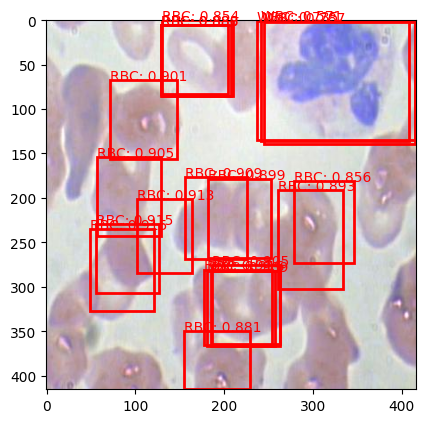

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    xmin, ymin, xmax, ymax = box.tolist()

    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor="r", facecolor="none")

    ax.add_patch(rect)

    ax.text(xmin, ymin, f"{model.config.id2label[label.item()]}: {score.item():.3f}", color="r")

plt.show()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


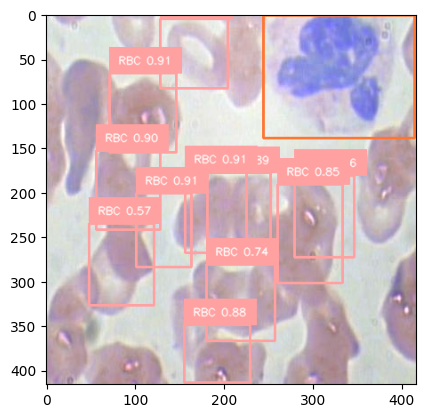

In [ ]:
import supervision as sv

detections = sv.Detections.from_transformers(results).with_nms(threshold=0.5)
scores = [score.item() for score in results["scores"]]
labels = [
    f"{model.config.id2label[class_id]} {score:.2f}"
    for class_id, score
    in zip(detections.class_id, scores)
]

box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator(
    text_scale=0.4,
    text_thickness=1,
)

annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
plt.imshow(annotated_frame)
plt.show()

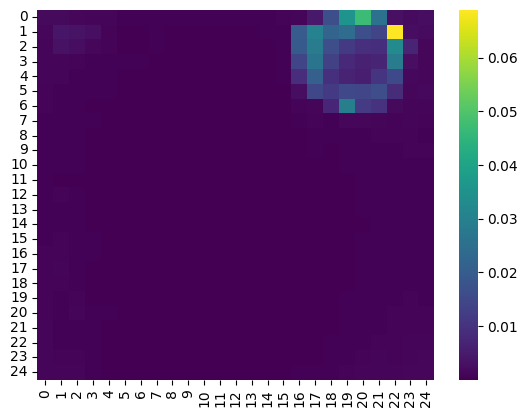

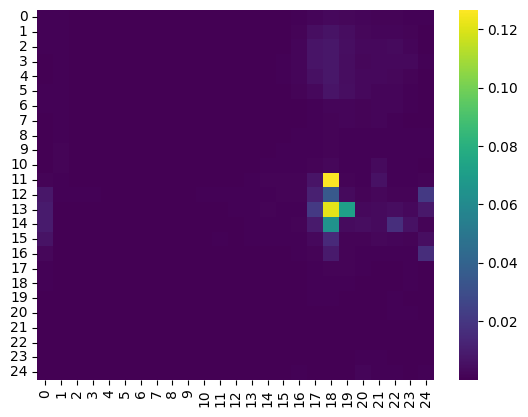

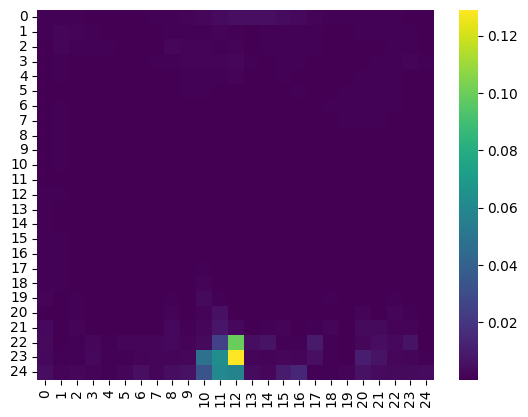

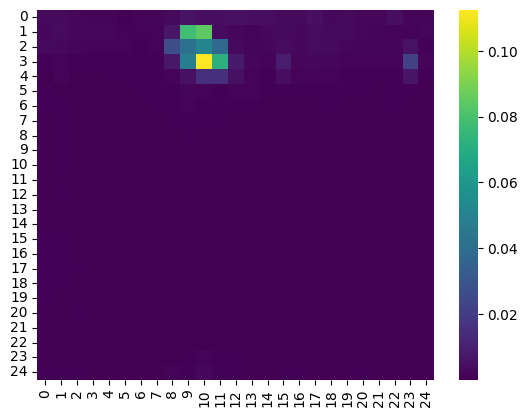

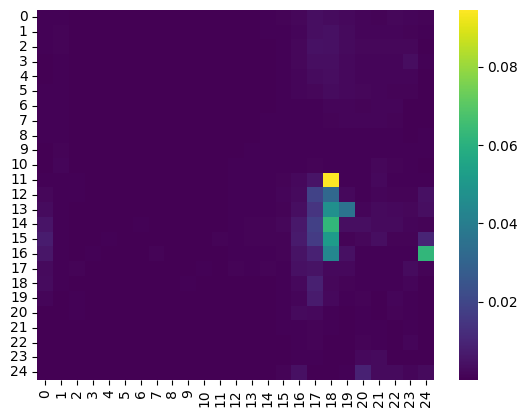

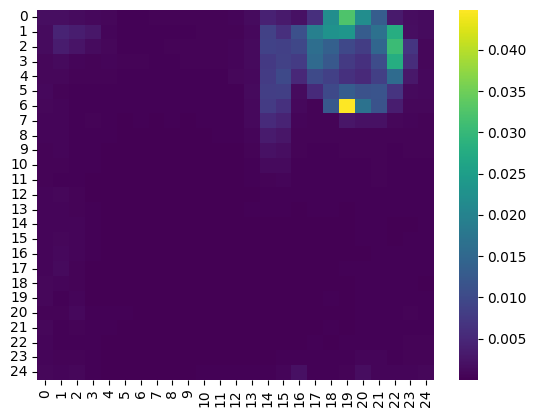

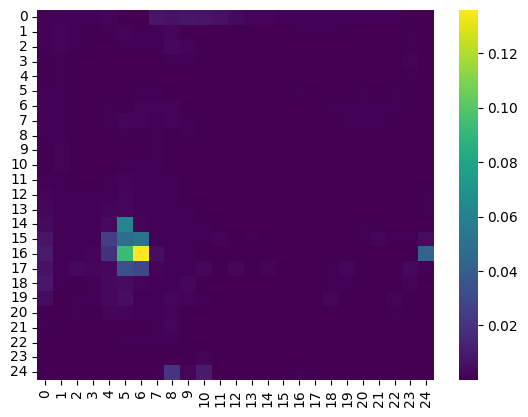

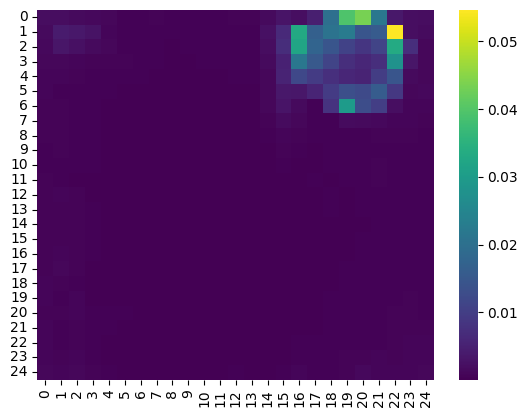

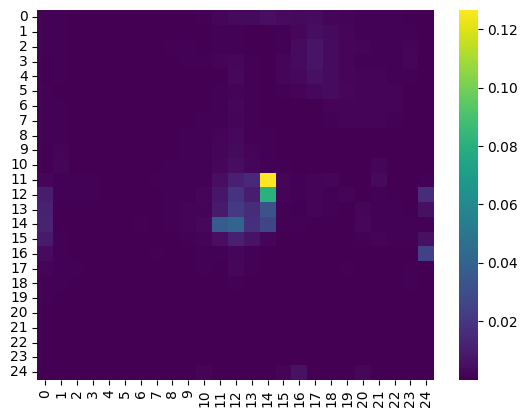

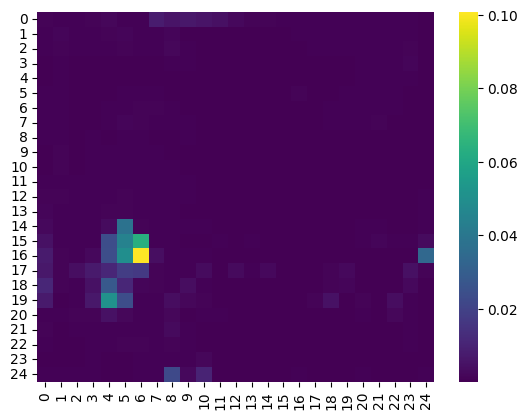

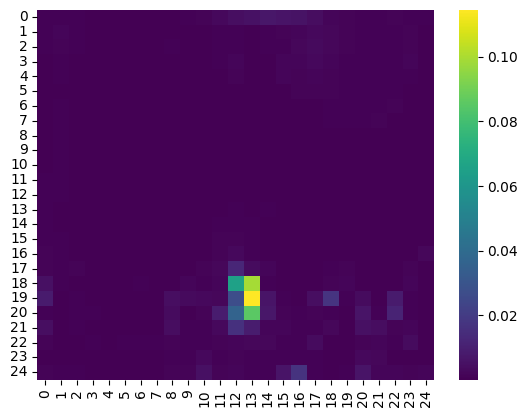

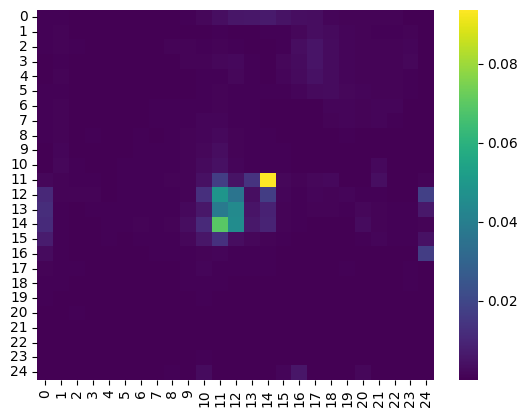

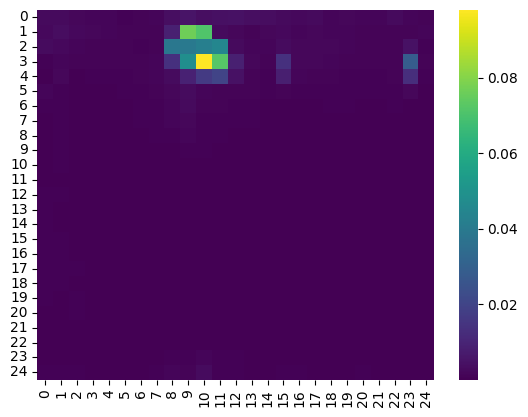

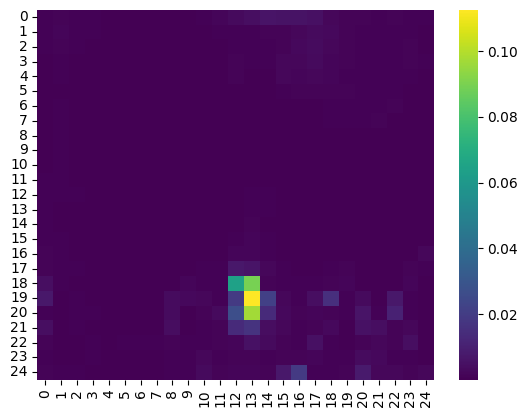

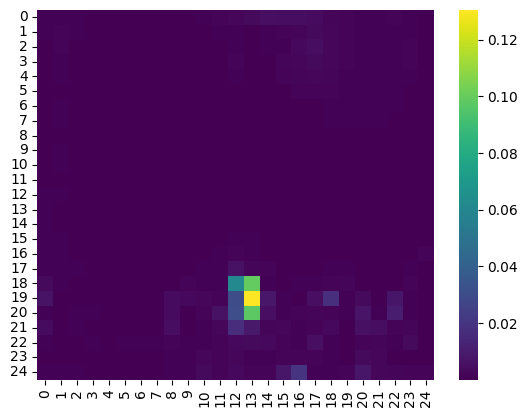

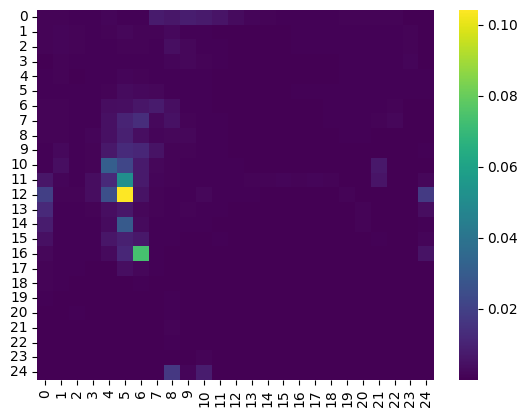

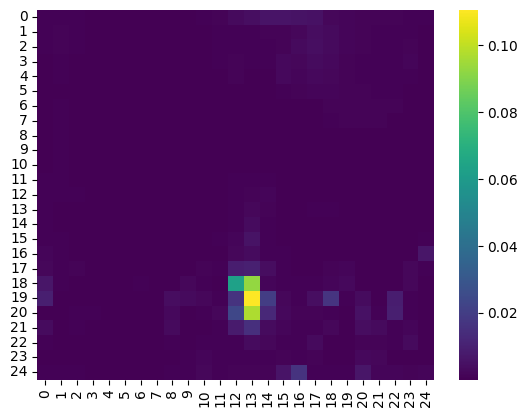

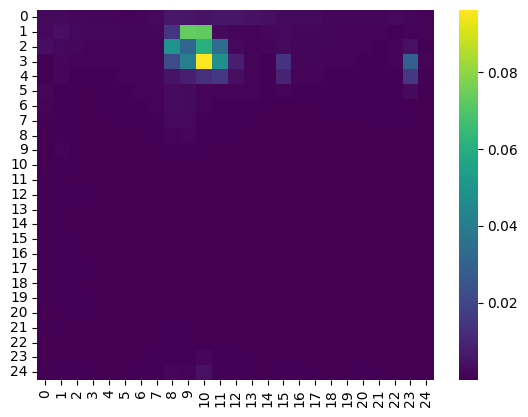

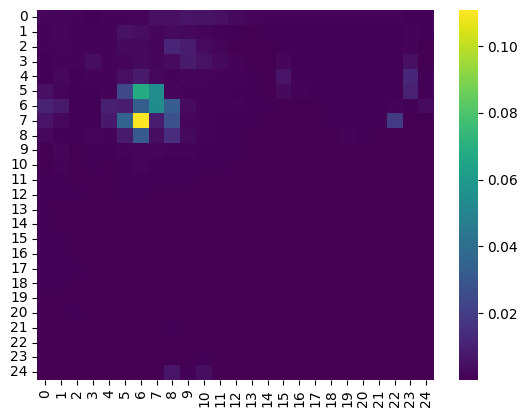

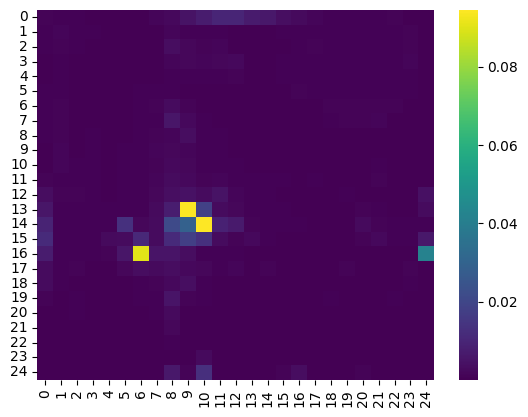

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

inputs = processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs, output_attentions=True)

attention_map = outputs.cross_attentions[-1][0]
attention_mean=torch.mean(attention_map, dim=0)
for attentions in attention_mean:
    h, w = inputs['pixel_values'].shape[-2:]
    attention_map_resized = attentions.reshape(h // 32, w // 32).detach().cpu().numpy()
    sns.heatmap(attention_map_resized, cmap="viridis")
    plt.show()

torch.Size([20, 625])


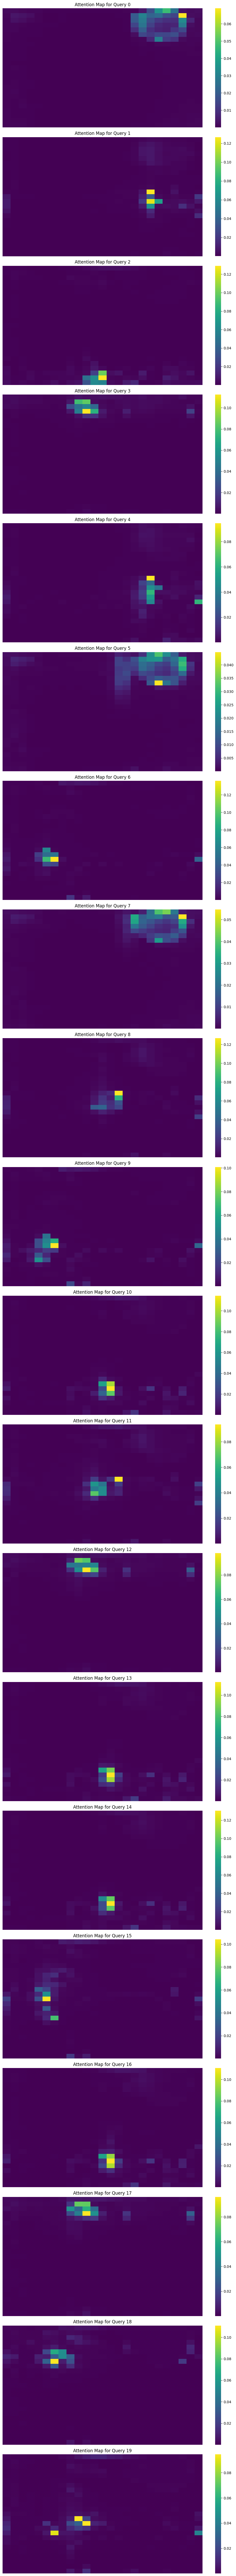

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.1

if len(keep.nonzero()) == 1:
    indices = keep.nonzero().squeeze(0)
else:
    indices = keep.nonzero().squeeze()

num_queries = len(indices)

if num_queries == 1:
    fig, axes = plt.subplots(figsize = (10, 5))
    axes = [axes]
else:
    fig, axes = plt.subplots(nrows=num_queries, ncols=1, figsize=(10, num_queries * 5))

all_head_attentions = outputs.cross_attentions[-1][0]  # (8, 100, 625)

mean_attention = torch.mean(all_head_attentions, dim=0)
for i in range(num_queries):
    attention_map = mean_attention[indices[i], :]  # (key_len)

    h, w = inputs['pixel_values'].shape[-2:]
    attention_map_resized = attention_map.reshape(25 , 25).detach().cpu().numpy() # Assuming feature map is 32x smaller

    sns.heatmap(attention_map_resized, cmap="viridis", ax=axes[i])
    axes[i].set_title(f"Attention Map for Query {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

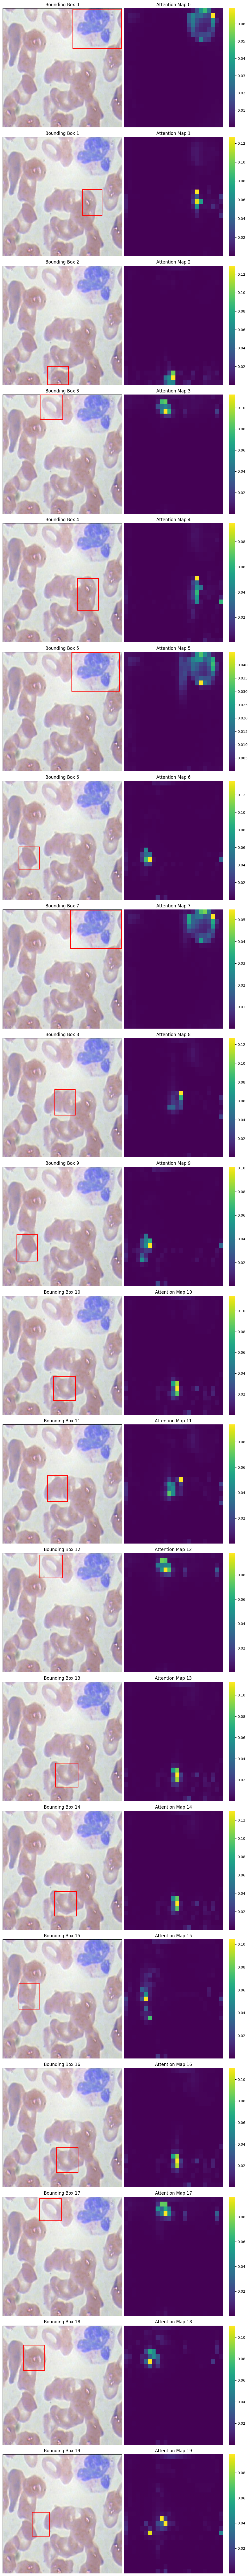

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np


probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.1

if len(keep.nonzero()) == 1:
    indices = keep.nonzero().squeeze(0)
else:
    indices = keep.nonzero().squeeze()

num_queries = len(indices)
fig, axes = plt.subplots(nrows=num_queries, ncols=2, figsize=(10, num_queries * 5))

for i in range(num_queries):
    box = results["boxes"][indices[i]].tolist()
    xmin, ymin, xmax, ymax = box

    cropped_image = image.crop((xmin, ymin, xmax, ymax))

    attention_map = outputs.cross_attentions[-1][0]
    attention_map = torch.mean(attention_map, dim=0)
    attention_map = attention_map[indices[i], :].reshape(25, 25).detach().cpu().numpy()

    axes[i, 0].imshow(image)
    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor="r", facecolor="none")
    axes[i, 0].add_patch(rect)
    axes[i, 0].set_title(f"Bounding Box {i}")
    axes[i, 0].axis("off")

    sns.heatmap(attention_map, cmap="viridis", ax=axes[i, 1])
    axes[i, 1].set_title(f"Attention Map {i}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()